In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scienceplots
from scipy.optimize import curve_fit
from typing import Union, Tuple, List, Dict
from nanonets.utils import load_boolean_results, fitness, abundance, abundance_plot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.style.use(["science","bright","grid"])

data_folder = "~/bagheera/data/1_funding_period/system_size_scaled/"
gates       = ['AND', 'OR', 'XOR', 'NAND', 'NOR', 'XNOR']

/home/jonasmensing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Results for $\delta = 0$

In [2]:
# Parameter
N_min   = 3
N_max   = 12
N_keys  = N_max-N_min+1
N_vals  = [i for i in range(N_min,N_max+1)]
N_e     = 8
delta   = 0.0

data            = load_boolean_results(folder=data_folder, N=N_vals, N_e=N_e, input_cols=['E1','E3'], max_error=np.inf)
fitness_data    = {N : fitness(df=data[N], input_cols=['E1','E3'], delta=delta) for N in N_vals}
abundance_data  = {N : abundance(df=fitness_data[N]) for N in N_vals}

### Box Plots

In [3]:
fitness_melted = pd.DataFrame()
for gate in gates:
    df              = pd.DataFrame([fitness_data[key].loc[:,f'{gate} Fitness'].copy().values for key in N_vals],index=np.array(N_vals)**2).T
    df              = df.melt(var_name='$N_{NP}$', value_name='$Fitness$').dropna().reset_index(drop=True)
    df['Gate']      = gate
    fitness_melted  = pd.concat([fitness_melted,df]).reset_index(drop=True)
fitness_melted

,$N_{NP}$,$Fitness$,Gate
0,9,3.425846,AND
1,9,3.070757,AND
2,9,6.052490,AND
3,9,3.140398,AND
4,9,3.478023,AND
...,...,...,...
1130395,144,2.847879,XNOR
1130396,144,-0.696321,XNOR
1130397,144,0.368756,XNOR
1130398,144,0.265246,XNOR


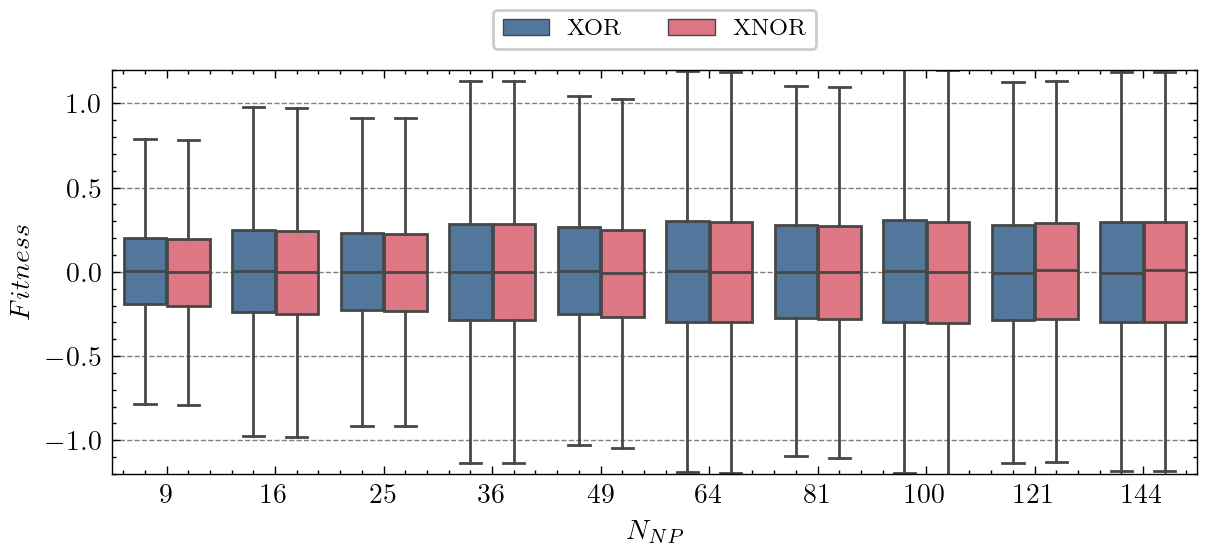

In [4]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot()
ax  = sns.boxplot(data=fitness_melted[(fitness_melted['Gate']=='XOR')|(fitness_melted['Gate']=='XNOR')], x='$N_{NP}$', y='$Fitness$', hue='Gate', ax=ax, fliersize=0)
ax.set_ylim(-1.2,1.2)
leg = ax.legend(loc='center', bbox_to_anchor=(0.5,1.1), ncol=6, fontsize='small')
leg.set_in_layout(True)

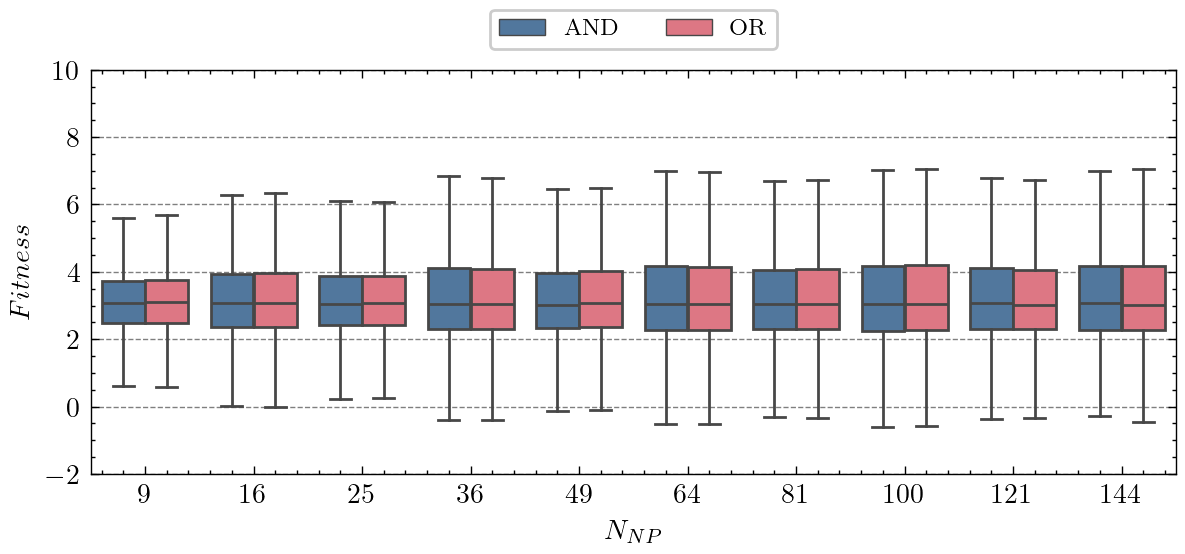

In [14]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot()
ax  = sns.boxplot(data=fitness_melted[(fitness_melted['Gate']=='AND')|(fitness_melted['Gate']=='OR')], x='$N_{NP}$', y='$Fitness$', hue='Gate', ax=ax, fliersize=0)
ax.set_ylim(-2,10)
leg = ax.legend(loc='center', bbox_to_anchor=(0.5,1.1), ncol=6, fontsize='small')
leg.set_in_layout(True)

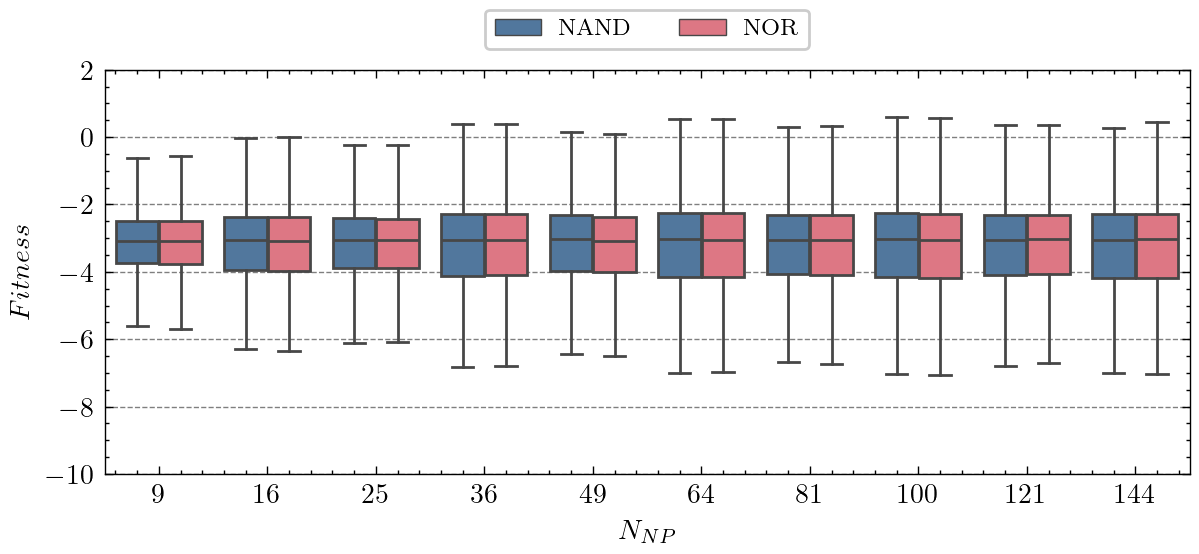

In [15]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot()
ax  = sns.boxplot(data=fitness_melted[(fitness_melted['Gate']=='NAND')|(fitness_melted['Gate']=='NOR')], x='$N_{NP}$', y='$Fitness$', hue='Gate', ax=ax, fliersize=0)
ax.set_ylim(-10,2)
leg = ax.legend(loc='center', bbox_to_anchor=(0.5,1.1), ncol=6, fontsize='small')
leg.set_in_layout(True)

In [5]:
def abundance_multiplot(data: Dict, gates: List[str] = ['AND', 'OR', 'XOR', 'NAND', 'NOR', 'XNOR'], 
    dpi: int = 200, x_limits: List[float] = [0.45, 10], y_limits: List[float] = [1.0, 100], 
    xlabel: str = 'Fitness', ylabel: str = 'Abundance', n_rows=2, n_cols=3, colormap='cividis') -> Tuple[plt.Figure, plt.Axes]:

    cmap    = plt.get_cmap(colormap)
    N_vals  = len(data.keys())

    with plt.style.context(["science","bright","grid"]):
        
        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, dpi=dpi, layout='constrained')
        fig.set_figwidth(fig.get_figwidth()*1.5)
        fig.set_figheight(fig.get_figheight()*1.1)

        for i, gate in enumerate(gates):
            ax      = axes.flat[i]
            keys    = []
            for j, (key, df) in enumerate(data.items()):
                ax.plot(df[f'{gate} Fitness'], df[f'{gate} Fitness Abundance'], color=cmap(j/N_vals))
                keys.append(key)
            ax.set_xlim(x_limits[0], x_limits[1])
            ax.set_ylim(y_limits[0], y_limits[1])
            ax.set_xscale('log')
            ax.set_yscale('log')
            
            if i >= (n_rows-1)*n_cols:
                ax.set_xlabel(xlabel)
            else:
                ax.set_xticklabels("")

            if i % n_cols == 0:
                ax.set_ylabel(ylabel)
            else:
                ax.set_yticklabels("")

            ax.set_title(gate)

        norm    = mpl.colors.Normalize(vmin=np.min(keys)**2, vmax=np.max(keys)**2)
        cbar    = mpl.cm.ScalarMappable(norm=norm, cmap=colormap)
        fig.colorbar(cbar, ax=axes.ravel(), label='$N_{NP}$')

    return fig, ax

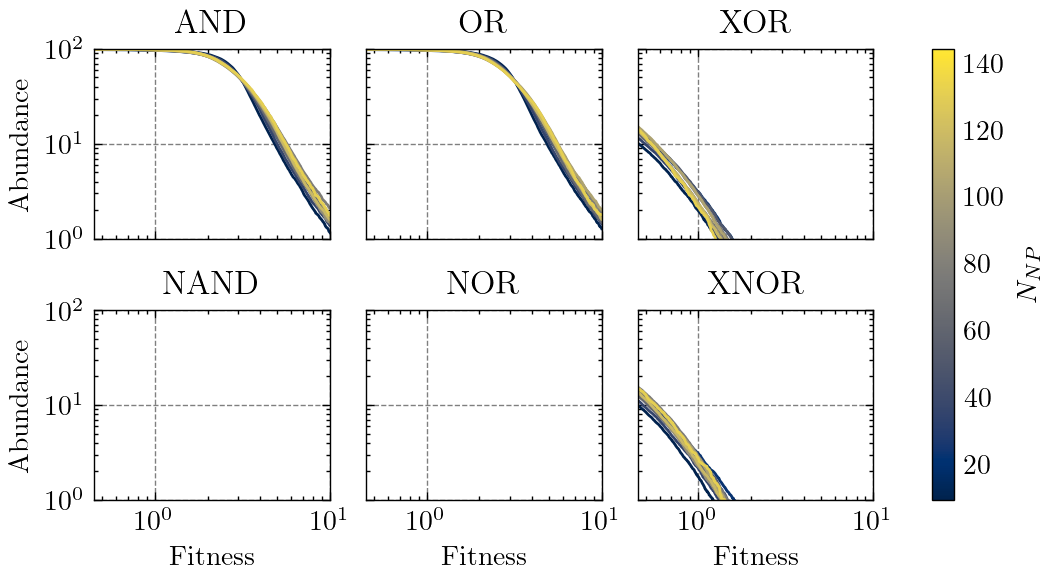

In [16]:
fig, ax = abundance_multiplot(abundance_data, y_limits=[1.0,100])
# fig.savefig(f"../plots/abundance/scaled_gate_vs_system_size_delta_{delta}.svg", transparent=True, bbox_inches='tight')
# fig.savefig(f"../plots/abundance/scaled_gate_vs_system_size_delta_{delta}.pdf", transparent=False, bbox_inches='tight')

In [ ]:
nand_fitness_3  = fitness_data[3].loc[:,'NAND Fitness'].copy().values
nand_fitness_16 = fitness_data[16].loc[:,'NAND Fitness'].copy().values
nand_fitness    = pd.DataFrame([nand_fitness_3, nand_fitness_16])
nand_fitness    = nand_fitness.T.melt(var_name='$N_{NP}$', value_name='NAND Fitness').dropna().reset_index(drop=True).replace(to_replace=0, value=9).replace(to_replace=1, value=256)
nand_fitness    = nand_fitness[nand_fitness>0].reset_index(drop=True)

xor_fitness_3   = fitness_data[3].loc[:,'XOR Fitness'].copy().values
xor_fitness_16  = fitness_data[16].loc[:,'XOR Fitness'].copy().values
xor_fitness     = pd.DataFrame([xor_fitness_3, xor_fitness_16])
xor_fitness     = xor_fitness.T.melt(var_name='$N_{NP}$', value_name='XOR Fitness').dropna().reset_index(drop=True).replace(to_replace=0, value=9).replace(to_replace=1, value=256)
xor_fitness     = xor_fitness[xor_fitness>0].reset_index(drop=True)

TypeError: 'function' object is not subscriptable

(0.02, 10.0)

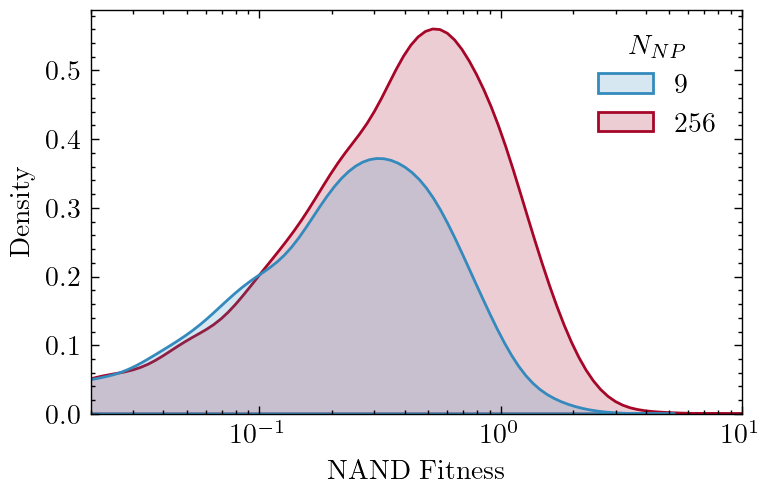

In [159]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.2)
ax  = fig.add_subplot()
# ax  = sns.histplot(nand_fitness, x='NAND Fitness', ax=ax, hue='$N_{NP}$', stat='density',
#                    log_scale=True, palette=[nanonets_utils.blue_color, nanonets_utils.red_color], multiple='stack')
ax  = sns.kdeplot(nand_fitness, x='NAND Fitness', ax=ax, hue='$N_{NP}$',
                   log_scale=True, palette=[nanonets_utils.blue_color, nanonets_utils.red_color], fill=True, alpha=0.2)
ax.set_xlim(2e-2, 1e1)

(0.02, 10.0)

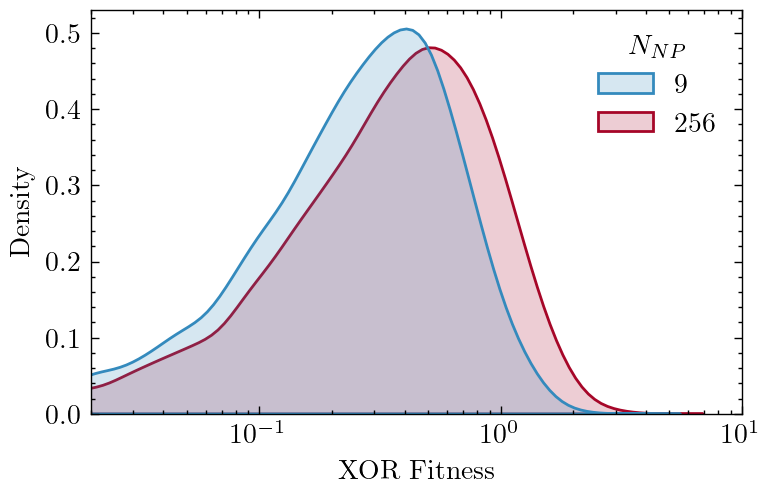

In [158]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.2)
ax  = fig.add_subplot()
# ax  = sns.histplot(xor_fitness, x='XOR Fitness', ax=ax, hue='$N_{NP}$', stat='density',
#                    log_scale=True, palette=[nanonets_utils.blue_color, nanonets_utils.red_color], multiple='stack')
ax  = sns.kdeplot(xor_fitness, x='XOR Fitness', ax=ax, hue='$N_{NP}$',
                   log_scale=True, palette=[nanonets_utils.blue_color, nanonets_utils.red_color], fill=True, alpha=0.2)
ax.set_xlim(2e-2, 1e1)

In [136]:
nand_list                   = [fitness[key].loc[:,'AND Fitness'].copy().values for key in N_vals]
nand_fitness                = pd.DataFrame(nand_list).T
nand_fitness                = nand_fitness.melt(var_name='$N_{NP}$', value_name='AND Fitness').dropna().reset_index(drop=True)
nand_fitness["$N_{NP}$"]    = (nand_fitness["$N_{NP}$"]+3)**2
nand_fitness

,$N_{NP}$,AND Fitness
0,9,2.707281
1,9,-0.360778
2,9,0.633428
3,9,3.985737
4,9,2.280187
...,...,...
352624,256,-0.996976
352625,256,-1.841282
352626,256,0.232687
352627,256,0.091337


(-5.0, 5.0)

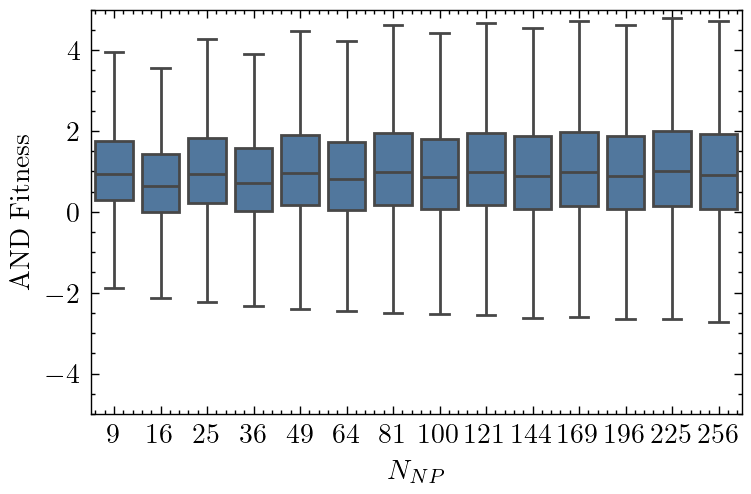

In [139]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.2)
ax  = fig.add_subplot()
ax  = sns.boxplot(nand_fitness, x='$N_{NP}$', y='AND Fitness', fliersize=0)
ax.set_ylim(-5,5)

In [140]:
nand_list                   = [fitness[key].loc[:,'XOR Fitness'].copy().values for key in N_vals]
nand_fitness                = pd.DataFrame(nand_list).T
nand_fitness                = nand_fitness.melt(var_name='$N_{NP}$', value_name='XOR Fitness').dropna().reset_index(drop=True)
nand_fitness["$N_{NP}$"]    = (nand_fitness["$N_{NP}$"]+3)**2
nand_fitness

,$N_{NP}$,XOR Fitness
0,9,-0.445890
1,9,1.273004
2,9,0.555740
3,9,-0.473777
4,9,-0.272716
...,...,...
352624,256,0.433236
352625,256,0.714924
352626,256,-1.029837
352627,256,0.100801


(-2.0, 2.0)

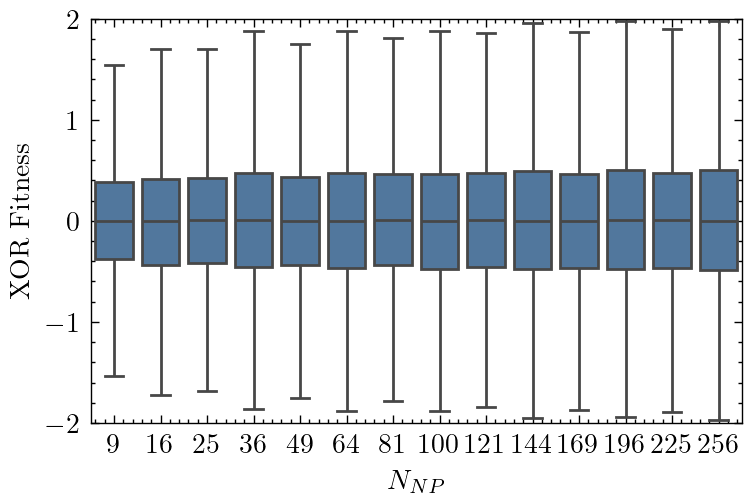

In [144]:
fig = plt.figure(dpi=200)
fig.set_figwidth(fig.get_figwidth()*1.2)
ax  = fig.add_subplot()
ax  = sns.boxplot(nand_fitness, x='$N_{NP}$', y='XOR Fitness', fliersize=0)
ax.set_ylim(-2,2)

In [109]:
nand_list       = [fitness[key].loc[:,'NAND Fitness'].copy().values for key in N_vals]
nand_fitness    = pd.DataFrame(nand_list)
nand_fitness_3  = fitness[3].loc[:,'NAND Fitness'].copy().values
nand_fitness_16 = fitness[16].loc[:,'NAND Fitness'].copy().values
nand_fitness    = pd.DataFrame([nand_fitness_3, nand_fitness_16])
nand_fitness    = nand_fitness.T.melt(var_name='$N_{NP}$', value_name='NAND Fitness').dropna().reset_index(drop=True).replace(to_replace=0, value=9).replace(to_replace=1, value=256)
nand_fitness    = nand_fitness[nand_fitness>0].reset_index(drop=True)

,$N_{NP}$,XOR Fitness
0,9,NaN
1,9,0.196082
2,9,0.107035
3,9,NaN
4,9,NaN
...,...,...
49587,256,0.092270
49588,256,0.130654
49589,256,NaN
49590,256,0.016866


<Axes: ylabel='XOR Fitness'>

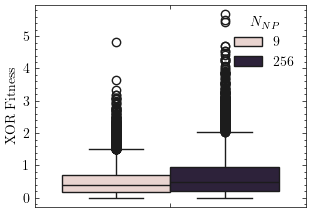

In [98]:
sns.boxplot(xor_fitness, hue='$N_{NP}$', y='XOR Fitness')

<Axes: ylabel='Count'>

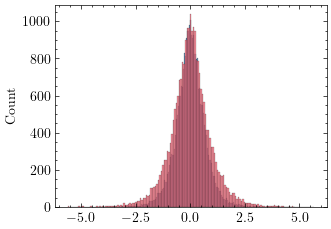

In [30]:
sns.histplot(xor_fitness_3)
sns.histplot(xor_fitness_16)

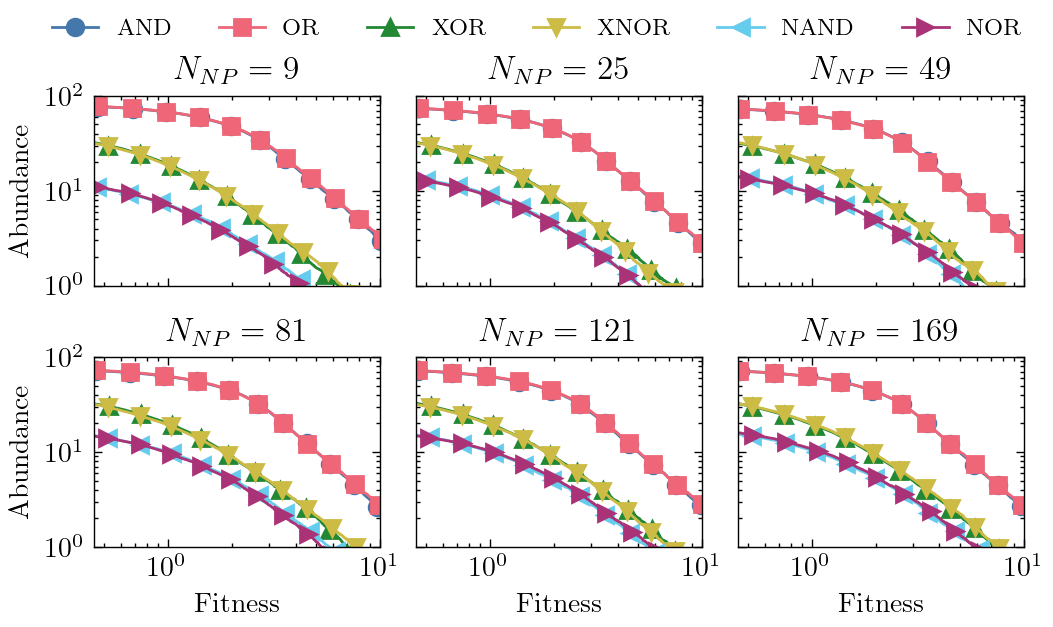

In [7]:
N_plots = [3,5,7,9,11,13]
gates   = ['AND', 'OR', 'XOR', 'XNOR', 'NAND', 'NOR']
marker  = ['o','s','^','v','<','>']
fig     = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.5)
fig.set_figheight(fig.get_figheight()*1.1)

for i, N in enumerate(N_plots):

    ax  = plt.subplot(2,3,i+1)
    for j, gate in enumerate(gates):
        ax.plot(abundance[N][f'{gate} Fitness'], abundance[N][f'{gate} Fitness Abundance'], label=gate, marker=marker[j % len(marker)], markevery=0.1)
    
    ax.set_xlim(0.45, 10)
    ax.set_ylim(1.0, 100)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('$N_{NP} = '+f'{N*N}$')
    
    if i % 3 == 0:
        ax.set_ylabel("Abundance")
    else:
        ax.set_yticklabels("")
    if i > 2:
        ax.set_xlabel("Fitness")
    else:
        ax.set_xticklabels("")
    
    if i==0:
        leg = ax.legend(loc='center', bbox_to_anchor=(1.55,1.35), ncol=6, fontsize='small')

leg.set_in_layout(False)
fig.canvas.draw()
leg.set_in_layout(True)
fig.set_layout_engine('none')
fig.savefig(f"../plots/abundance/scaled_system_size_comparison_delta_{delta}.svg", transparent=True, bbox_inches='tight')
fig.savefig(f"../plots/abundance/scaled_system_size_comparison_delta_{delta}.pdf", transparent=False, bbox_inches='tight')

## Nonlinear Parameter

In [ ]:
# Current Relations
n_bootstrap = 1000
params      = {N : nanonets_utils.nonlinear_parameter(data[N], on_state=U_on[i], n_bootstrap=n_bootstrap) for i, N in enumerate(N_vals)}

# NDR / NLS
bins    = 'fd'
Q_ndr   = []
Q_nls   = []
for i in range(n_bootstrap): 

    Q_ndr_l =   np.array([nanonets_utils.return_ndr(params[N][i]['Ml']) for N in N_vals])
    Q_ndr_r =   np.array([nanonets_utils.return_ndr(params[N][i]['Mr']) for N in N_vals])
    Q_ndr.append((Q_ndr_l + Q_ndr_r) / 2)

    Q_nls.append(np.array([nanonets_utils.return_nls(df=params[N][i], bins=bins) for N in N_vals]))

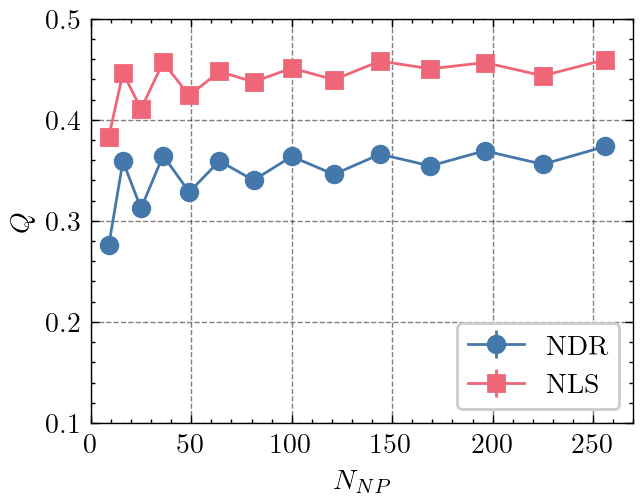

In [9]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    
    ax.errorbar(np.array(N_vals)**2, np.mean(Q_ndr,axis=0), 1.96*np.std(Q_ndr,axis=0), marker='o', label='NDR')
    ax.errorbar(np.array(N_vals)**2, np.mean(Q_nls,axis=0), 1.96*np.std(Q_ndr,axis=0), marker='s', label='NLS')

    ax.set_xlabel('$N_{NP}$')
    ax.set_ylabel('$Q$')
    ax.legend(loc='lower right')
    ax.set_xlim(0,270)
    ax.set_ylim(0.1,0.5)

# fig.savefig("../plots/scaled_nonlinearity_vs_system_size_scaled.svg", transparent=True, bbox_inches='tight')
# fig.savefig("../plots/scaled_nonlinearity_vs_system_size_scaled.pdf", transparent=False, bbox_inches='tight')

In [4]:
# Current Relations
n_bootstrap = 0
params      = {N : nanonets_utils.nonlinear_parameter(data[N], on_state=U_on[i], n_bootstrap=n_bootstrap) for i, N in enumerate(N_vals)}

# # NDR
Q_ndr_l = np.array([nanonets_utils.return_ndr(params[N]['Ml']) for N in N_vals])
Q_ndr_r = np.array([nanonets_utils.return_ndr(params[N]['Mr']) for N in N_vals])
Q_ndr   = (Q_ndr_l + Q_ndr_r) / 2

# NLS
bins    = 'fd'
Q_nls   = np.array([nanonets_utils.return_nls(df=params[N], bins=bins) for N in N_vals])

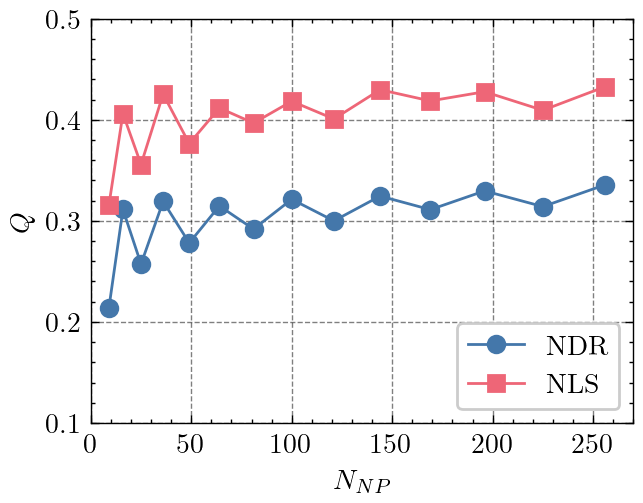

In [5]:
with plt.style.context(["science","bright","grid"]):

    fig = plt.figure(dpi=200)
    ax  = fig.add_subplot()
    
    ax.plot(np.array(N_vals)**2, Q_ndr, '-o', label='NDR')
    ax.plot(np.array(N_vals)**2, Q_nls, '-s', label='NLS')

    ax.set_xlabel('$N_{NP}$')
    ax.set_ylabel('$Q$')
    ax.legend(loc='lower right')
    ax.set_xlim(0,270)
    ax.set_ylim(0.1,0.5)

fig.savefig("../plots/scaled_nonlinearity_vs_system_size_scaled.svg", transparent=True, bbox_inches='tight')
fig.savefig("../plots/scaled_nonlinearity_vs_system_size_scaled.pdf", transparent=False, bbox_inches='tight')

---

## Best Gates

In [46]:
N       = 11
gate    = 'XOR'
best_g  = nanonets_utils.get_best_logic_gate(data[N], fitness[N], gate)
best_g

,E0,E1,E2,E3,E4,E5,E6,E7,G,Eq_Jumps,Jumps,Current,Error
0,0.0019,0.0000,0.0483,0.0000,0.0303,-0.0831,-0.0517,0.0443,0.0,100000.0,70000.0,-338.854439,11.630212
1,0.0019,0.0000,0.0483,0.0114,0.0303,-0.0831,-0.0517,0.0443,0.0,100000.0,55000.0,-309.676136,9.460792
2,0.0019,0.0114,0.0483,0.0000,0.0303,-0.0831,-0.0517,0.0443,0.0,100000.0,30000.0,-301.406572,5.886634
3,0.0019,0.0114,0.0483,0.0114,0.0303,-0.0831,-0.0517,0.0443,0.0,100000.0,45000.0,-331.212717,10.915698


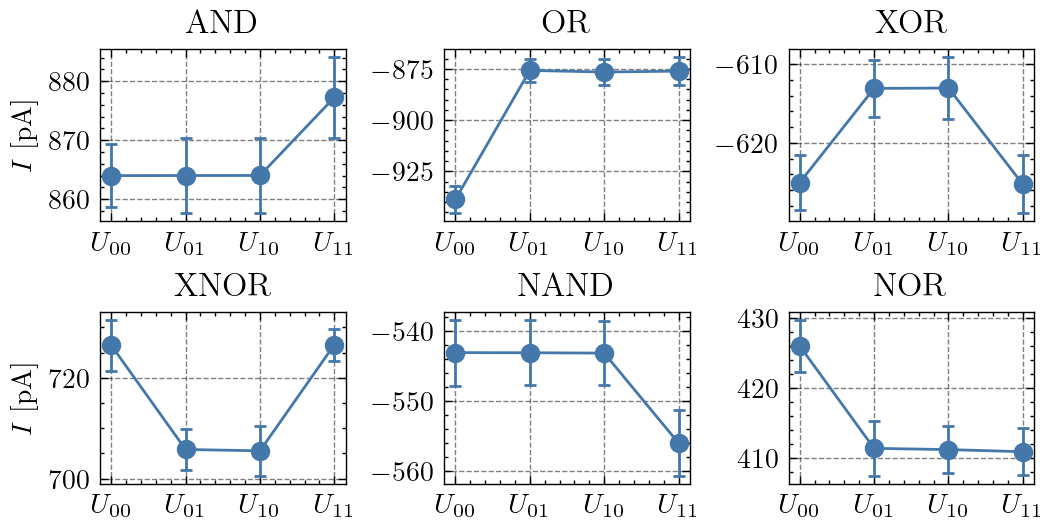

In [9]:
N = 15

with plt.style.context(["science","bright","grid"]):
    
    fig = plt.figure(dpi=200, layout='constrained')
    fig.set_figwidth(fig.get_figwidth()*1.5)
    fig.set_figheight(fig.get_figheight()*1)

    for i, gate in enumerate(['AND', 'OR', 'XOR', 'XNOR', 'NAND', 'NOR']):

        best_g  = nanonets_utils.get_best_logic_gate(data[N], fitness[N], gate)
        ax      = fig.add_subplot(2,3,i+1)
        ax.errorbar(["$U_{00}$","$U_{01}$","$U_{10}$","$U_{11}$"], best_g['Current'], best_g['Error'], marker='o', capsize=2)
        ax.set_title(gate)

        if i % 3 == 0:
            ax.set_ylabel("$I$ [pA]")

fig.savefig(f"../plots/scaled_best_gates_delta_{delta}.svg", transparent=True, bbox_inches='tight')
fig.savefig(f"../plots/scaled_best_gates_delta_{delta}.pdf", transparent=False, bbox_inches='tight')

In [48]:
max_jumps_portion   = [100*((data[N]['Jumps']==1e7).sum() / len(data[N])) for N in N_vals]
rel_error_dist      = [100*np.abs(data[N]['Error'].values / data[N]['Current'].values) for N in N_vals]

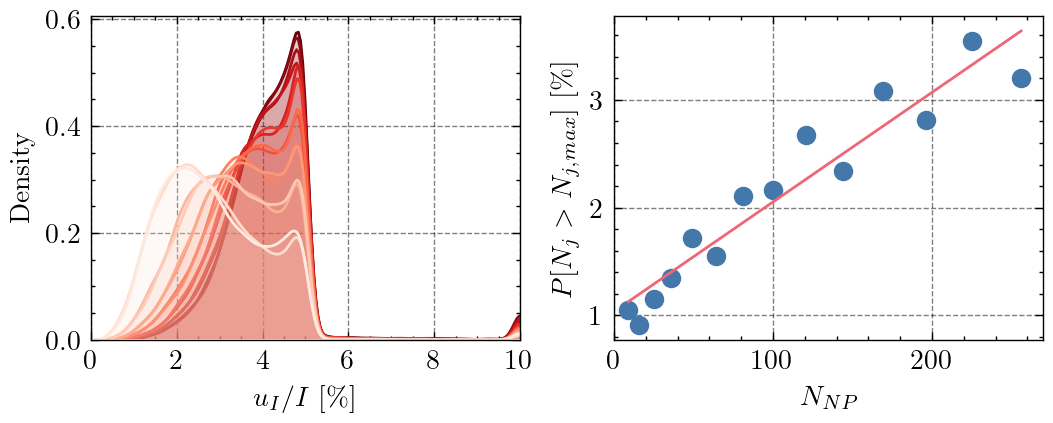

In [49]:
def lin_func(x, a, b):
    return a*x + b

with plt.style.context(["science","bright","grid"]):

    cmap    = plt.get_cmap('Reds')
    fig     = plt.figure(dpi=200, layout='constrained')
    ax1     = fig.add_subplot(1,2,1)
    ax2     = fig.add_subplot(1,2,2)
    fig.set_figwidth(fig.get_figwidth()*1.5)
    fig.set_figheight(fig.get_figheight()*0.8)

    for i, arr in enumerate(rel_error_dist[::-1]):
        arr[arr>10] = 10
        ax1         = sns.kdeplot(arr, ax=ax1, color=cmap((len(rel_error_dist)-i)/len(rel_error_dist)), fill=True, alpha=0.1)

    ax1.set_xlim(0,10)
    ax1.set_xlabel('$u_I / I$ [\%]')

    x       = np.array(N_vals)**2
    y       = max_jumps_portion
    p, _    = curve_fit(lin_func, x, y)
    ax2.plot(x, y, 'o')
    ax2.plot(x, lin_func(x,*p), '-')
    ax2.set_xlabel('$N_{NP}$')
    ax2.set_ylabel('$P[N_{j} > N_{j,max}]$ [\%]')
    ax2.set_xlim(0,270)

    # fig.savefig("../plots/data_quality_vs_system_size.svg", transparent=True, bbox_inches='tight')
    # fig.savefig("../plots/data_quality_vs_system_size.pdf", transparent=False, bbox_inches='tight')